In [0]:
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models
import time
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


In [0]:
img_rows = 28
img_cols = 28
channels = 1
z_dim = 100 # A vector of 100 randomized values for noise vector
img_shape = (img_rows, img_cols, channels)

In [0]:
# build geneartor model
def make_generator_model(img_shape, z_dim):
  model=models.Sequential()
  model.add(layers.Dense(128, input_dim=z_dim))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.2))

  model.add(layers.Dense(28*28*1, activation='tanh')) # Tanh produces a crisper images somehow
  model.add(layers.BatchNormalization())
  model.add(layers.Reshape(img_shape))

  return model


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



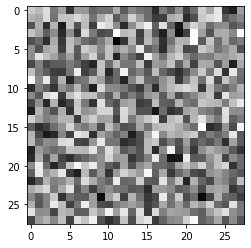

In [0]:
# generate current image of noise
generator = make_generator_model(img_shape, z_dim)
noise = np.random.normal(0, 1, (1,100))
generated_image=generator(noise, training= False)
plt.imshow(generated_image[0,:,:,0], cmap='gray')

In [0]:
# build discriminator model
def make_discriminator_model(img_shape):
  model=models.Sequential()
  model.add(layers.Flatten(input_shape=img_shape))
  model.add(layers.Dense(128))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(1, activation='sigmoid'))
  
  return model

In [0]:
# build GAN model
def make_gan_model(generator, discriminator):
  model = models.Sequential()
  model.add(generator)
  model.add(discriminator)

  return model

discriminator = make_discriminator_model(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
generator = make_generator_model(img_shape, z_dim)
discriminator.trainable=False
gan = make_gan_model(generator, discriminator)
gan.compile(loss='binary_crossentropy',
            optimizer='adam')




In [0]:
# train the model
losses = []
accuracies = []
iteration_checkpoints = []
def train(iterations, batch_size, sample_interval):
  (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
  train_images = train_images/127.5 - 1.0
  train_images = np.expand_dims(train_images, axis=3)
  real=np.ones((batch_size, 1))
  fake=np.zeros((batch_size, 1))
  for iteration in range(iterations):
    idx = np.random.randint(0, train_images.shape[0], batch_size)
    real_imgs = train_images[idx]

    z = np.random.normal(0,1,(batch_size, 100))
    gen_imgs = generator.predict(z)
    d_loss_real = discriminator.train_on_batch(real_imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

    z = np.random.normal(0,1,(batch_size, 100))
    gen_imgs = generator.predict(z)
    g_loss = gan.train_on_batch(z, real) # check this - Book writes z but doesnt make sense
    if (iteration + 1) % sample_interval == 0:
      losses.append((d_loss, g_loss))
      accuracies.append(100.0*accuracy)
      iteration_checkpoints.append(iteration + 1)
      print("%d [D loss: %f, acc: %.2f] [G loss: %f]" %
            (iteration+1, d_loss, 100.0*accuracy, g_loss))
      sample_images(generator)  

In [0]:
# Displaying generated images
def sample_images(generator, image_grid_rows = 4, image_grid_columns = 4):
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
  gen_imgs = generator.predict(z)
  gen_imgs = 0.5 * gen_imgs + 0.5 # Rescale pixel to [0,1]. Originally after tanh is [-1,1]
  fig, axs = plt.subplots(image_grid_rows,
                          image_grid_columns,
                          figsize = (4,4),
                          sharey = True,
                          sharex = True)
  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1

1000 [D loss: 0.006739, acc: 100.00] [G loss: 4.005466]
2000 [D loss: 0.049677, acc: 98.83] [G loss: 4.695171]
3000 [D loss: 0.124091, acc: 95.31] [G loss: 2.727615]
4000 [D loss: 0.021630, acc: 99.61] [G loss: 1.146594]
5000 [D loss: 0.142749, acc: 95.31] [G loss: 0.335844]
6000 [D loss: 0.437439, acc: 81.64] [G loss: 0.432491]
7000 [D loss: 0.620976, acc: 75.00] [G loss: 0.637408]
8000 [D loss: 0.541596, acc: 73.05] [G loss: 0.345743]
9000 [D loss: 0.711234, acc: 63.67] [G loss: 0.781806]
10000 [D loss: 0.322368, acc: 88.67] [G loss: 0.108687]
11000 [D loss: 0.481641, acc: 80.86] [G loss: 0.328412]
12000 [D loss: 0.504834, acc: 76.17] [G loss: 0.644875]
13000 [D loss: 0.260304, acc: 90.23] [G loss: 0.409868]
14000 [D loss: 0.141467, acc: 95.31] [G loss: 0.238636]
15000 [D loss: 0.036292, acc: 99.61] [G loss: 0.067551]
16000 [D loss: 0.023650, acc: 98.83] [G loss: 0.039862]
17000 [D loss: 0.023233, acc: 99.22] [G loss: 0.013616]
18000 [D loss: 0.116196, acc: 93.75] [G loss: 0.721767]


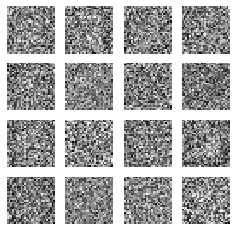

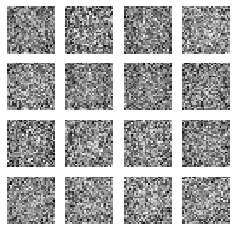

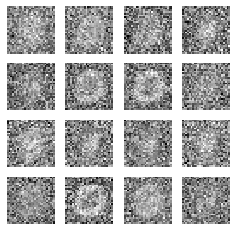

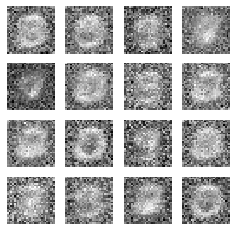

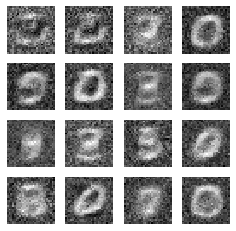

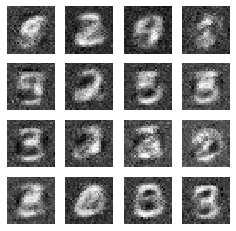

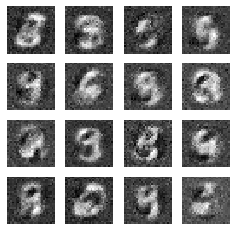

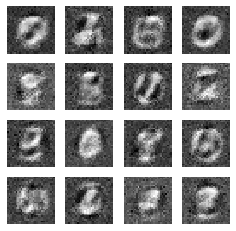

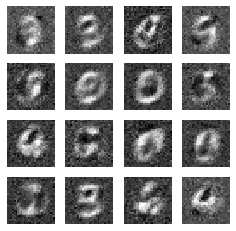

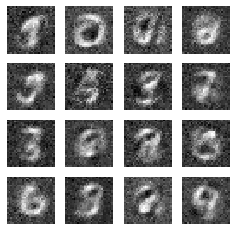

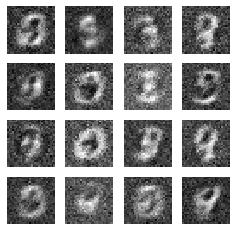

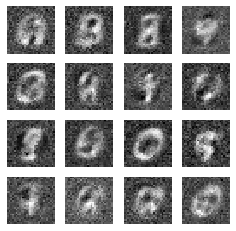

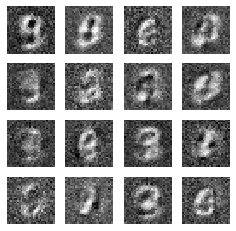

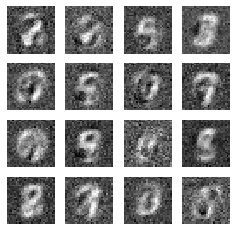

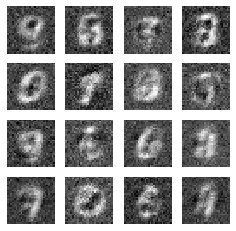

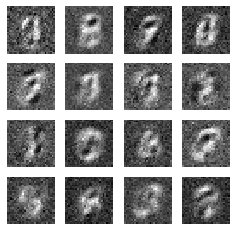

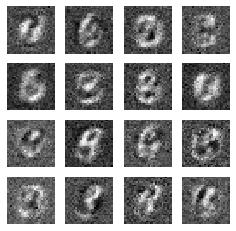

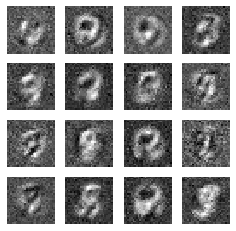

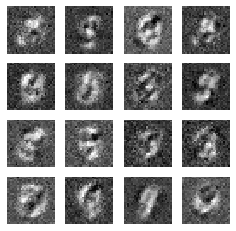

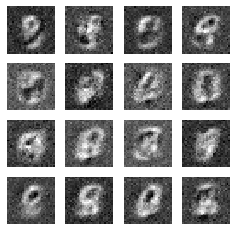

In [0]:
iterations = 20000
batch_size = 128
sample_interval = 1000
train(iterations, batch_size, sample_interval)

In [0]:
img_shape = (28, 28 ,1)
model = models.Sequential()
model.add(layers.Conv2D(64, kernel_size = 3, strides = 2, input_shape = (img_shape[0], img_shape[1], img_shape[2]+1), padding='same'))
model.add(layers.LeakyReLU(alpha=0.01))
    # Add conv layer 7x7x64
model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.01))

    # Add conv layer 3x3x128
    # Add conv layer 14x14x64
model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.LeakyReLU(alpha=0.01))

    # Flatten and output layer
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 14, 14, 64)        1216      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
batch_normalization_6 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
batch_normalization_7 (Batch (None, 4, 4, 128)        